# IMPORT LIBRARIES/DATASETS

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import the necessary packages

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import matplotlib.pyplot as plt
import PIL
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from IPython.display import display
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Flatten, Activation, BatchNormalization, Dropout, Dense

In [3]:
datafolder = "/content/drive/MyDrive/FY_BTech_Project/data"
os.chdir("/content/drive/MyDrive/FY_BTech_Project")

In [4]:
# Check the number of images in the dataset
data = []
label = []

# os.listdir returns the list of files in the folder, in this case image class names
for i in os.listdir(datafolder):
  train_class = os.listdir(os.path.join('data', i))
  for j in train_class:
    img = os.path.join('data', i, j)
    data.append(img)
    label.append(i)

print('Number of train images : {} \n'.format(len(data)))


Number of train images : 3662 



# PERFORM DATA EXPLORATION AND DATA VISUALIZATION

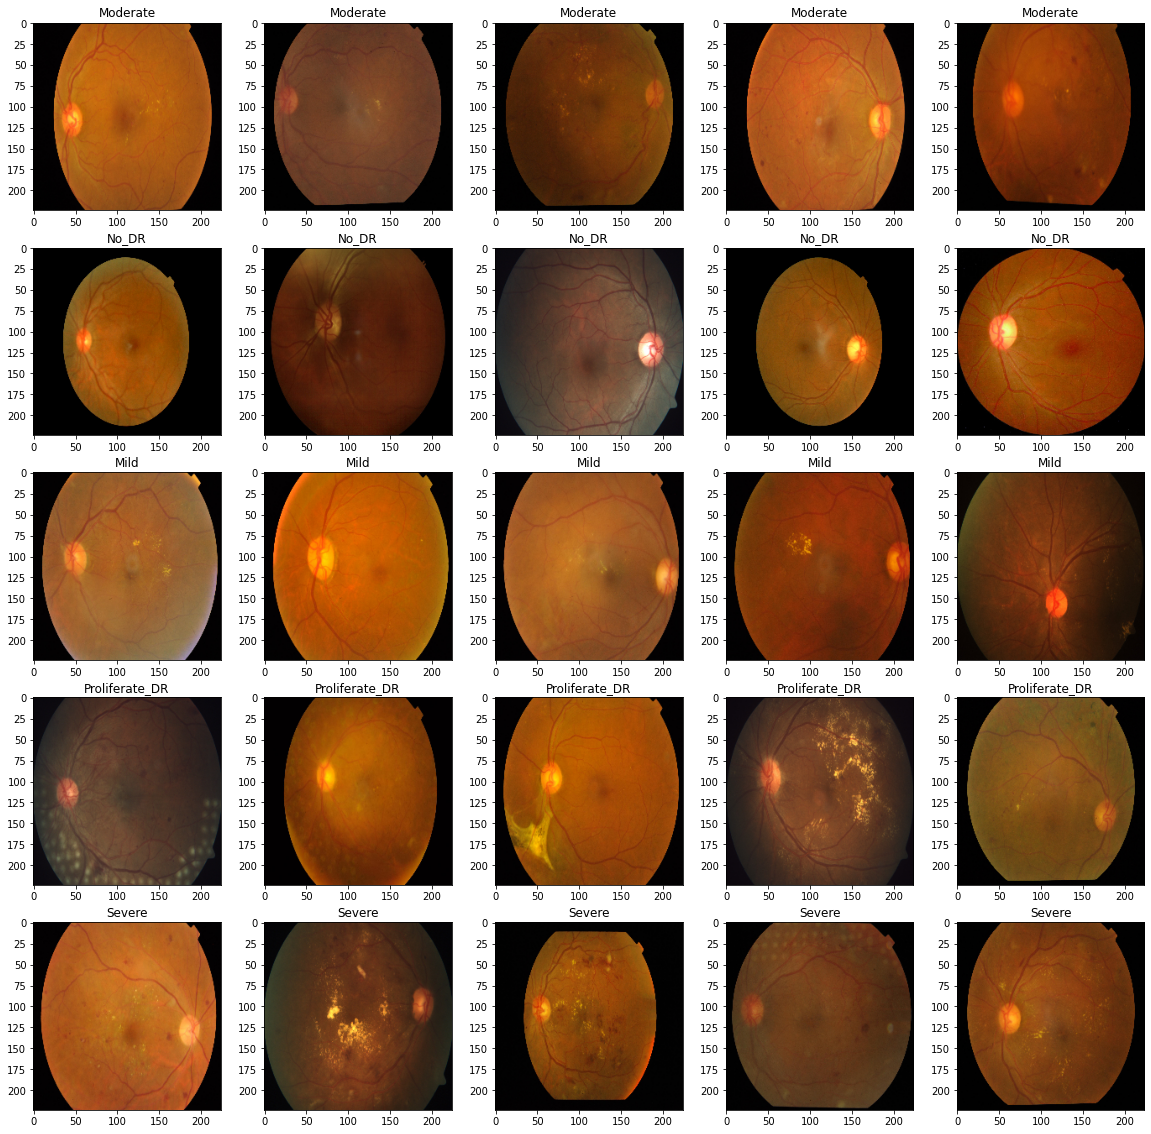

In [ ]:
# Visualize 5 images for each class in the dataset

fig, axs = plt.subplots(5, 5, figsize = (20, 20))
count = 0
for i in os.listdir(datafolder):
  # get the list of images in a given class
  train_class = os.listdir(os.path.join('data', i))
  # plot 5 images per class
  for j in range(5):
    img = os.path.join('data', i, train_class[j])
    img = PIL.Image.open(img)
    axs[count][j].title.set_text(i)
    axs[count][j].imshow(img)  
  count += 1

In [5]:
# check the number of images in each class in the training dataset

No_images_per_class = []
Class_name = []
total = 0;
for i in os.listdir(datafolder):
  train_class = os.listdir(os.path.join('data', i))
  No_images_per_class.append(len(train_class))
  Class_name.append(i)
  print('Number of images in {} = {} \n'.format(i, len(train_class)))
  total+=len(train_class)  
print("\n\tNumber of total images = {}".format(total))

Number of images in Moderate = 999 

Number of images in No_DR = 1805 

Number of images in Mild = 370 

Number of images in Proliferate_DR = 295 

Number of images in Severe = 193 


	Number of total images = 3662


In [6]:
retina_df = pd.DataFrame({'Image': data,'Labels': label})
retina_df

Image    Labels
0     data/Moderate/0afdfe5f422c.png  Moderate
1     data/Moderate/064af6592ba6.png  Moderate
2     data/Moderate/0a1076183736.png  Moderate
3     data/Moderate/0af296d2f04a.png  Moderate
4     data/Moderate/01c7808d901d.png  Moderate
...                              ...       ...
3657    data/Severe/762d6e5d5068.png    Severe
3658    data/Severe/c67117c6ab3b.png    Severe
3659    data/Severe/f5a8c6426a71.png    Severe
3660    data/Severe/916ec976ff30.png    Severe
3661    data/Severe/e32a359be36d.png    Severe

[3662 rows x 2 columns]

# PERFORM DATA AUGMENTATION AND CREATE DATA GENERATOR

In [7]:
# Shuffle the data and split it into training and testing
retina_df = shuffle(retina_df)
train, test = train_test_split(retina_df, test_size = 0.20)

In [8]:
# Create run-time augmentation on training and test dataset
# For training datagenerator, we add normalization, shear angle, zooming range and horizontal flip

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split = 0.15)

# For test datagenerator, we only normalize the data.
test_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest")

In [9]:
# Creating datagenerator for training, validation and test dataset.

train_generator = train_datagen.flow_from_dataframe(
    train,
    directory='./',
    x_col="Image",
    y_col="Labels",
    target_size=(256, 256),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    subset='training')

validation_generator = train_datagen.flow_from_dataframe(
    train,
    directory='./',
    x_col="Image",
    y_col="Labels",
    target_size=(256, 256),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    subset='validation')

test_generator = test_datagen.flow_from_dataframe(
    test,
    directory='./',
    x_col="Image",
    y_col="Labels",
    target_size=(256, 256),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32)

Found 2490 validated image filenames belonging to 5 classes.
Found 439 validated image filenames belonging to 5 classes.
Found 733 validated image filenames belonging to 5 classes.


# BUILD RES-BLOCK BASED DEEP LEARNING MODEL

In [ ]:
def vgg_net():
    model = Sequential()
    inputShape = (256,256,3)

    # CONV => RELU => POOL
    model.add(Conv2D(32, (9,9), padding="same", input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=1))
    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(Dropout(0.25))

    # (CONV => RELU) * 2 => POOL
    model.add(Conv2D(64, (5,5), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=1))
    model.add(Conv2D(64, (5,5), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    # (CONV => RELU) * 2 => POOL
    model.add(Conv2D(128, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=1))
    model.add(Conv2D(128, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    # first (and only) set of FC => RELU layers
    model.add(Flatten())
    model.add(Dense(5))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    # softmax classifier
    model.add(Dense(5))
    model.add(Activation("softmax"))

    # return the constructed network architecture
    return model

In [ ]:
model = vgg_net()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 256, 256, 32)      7808      
                                                                 
 activation_7 (Activation)   (None, 256, 256, 32)      0         
                                                                 
 batch_normalization_6 (Batc  (None, 256, 256, 32)     1024      
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 85, 85, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 85, 85, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 85, 85, 64)       

# COMPILE AND TRAIN DEEP LEARNING MODEL

In [ ]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics= ['accuracy'])

In [ ]:
#using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='accuracy', mode='auto', verbose=1, patience=20)

#save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="/content/drive/MyDrive/FY_BTech_Project/Saved Models/vggnet19_final.h5", verbose = 1, save_best_only=True)

In [ ]:
history = model.fit(train_generator, steps_per_epoch = train_generator.n // 32, epochs = 100, validation_data= validation_generator, validation_steps= validation_generator.n // 32, callbacks=[checkpointer , earlystopping])

Epoch 1/100
71/71 [==============================] - ETA: 0s - loss: 1.4989 - accuracy: 0.4587
Epoch 1: val_loss improved from inf to 1.63141, saving model to /content/drive/MyDrive/FY_BTech_Project/Saved Models/vggnet19_final.h5
71/71 [==============================] - 109s 1s/step - loss: 1.4989 - accuracy: 0.4587 - val_loss: 1.6314 - val_accuracy: 0.5026
Epoch 2/100
71/71 [==============================] - ETA: 0s - loss: 1.2414 - accuracy: 0.6189
Epoch 2: val_loss improved from 1.63141 to 1.54244, saving model to /content/drive/MyDrive/FY_BTech_Project/Saved Models/vggnet19_final.h5
71/71 [==============================] - 46s 652ms/step - loss: 1.2414 - accuracy: 0.6189 - val_loss: 1.5424 - val_accuracy: 0.4974
Epoch 3/100
71/71 [==============================] - ETA: 0s - loss: 1.1674 - accuracy: 0.6216
Epoch 3: val_loss did not improve from 1.54244
71/71 [==============================] - 43s 612ms/step - loss: 1.1674 - accuracy: 0.6216 - val_loss: 1.6356 - val_accuracy: 0.5000


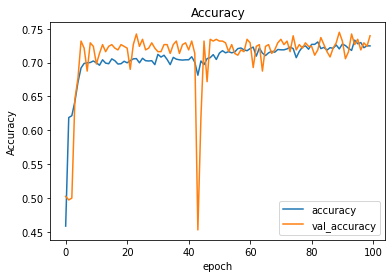

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy','val_accuracy'], loc = 'lower right')
plt.show()

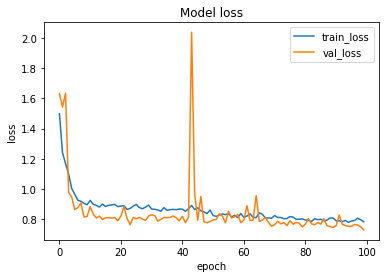

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'], loc = 'upper right')
plt.show()

# ASSESS THE PERFORMANCE OF THE TRAINED MODEL

In [10]:
# Evaluate the performance of the model
from keras.models import load_model
saved_model = load_model("/content/drive/MyDrive/FY_BTech_Project/Saved Models/vggnet19_final.h5")
evaluate = saved_model.evaluate(test_generator, steps = test_generator.n // 32, verbose =1)

22/22 [==============================] - 618s 29s/step - loss: 0.7454 - accuracy: 0.7188


In [11]:
print('Accuracy Test : {:.4f} %'.format(evaluate[1]*100))
print('Loss Test : {:.4f}'.format(evaluate[0]))

Accuracy Test : 71.8750 %
Loss Test : 0.7454


In [12]:
# Assigning label names to the corresponding indexes
labels = {0: 'Mild', 1: 'Moderate', 2: 'No_DR', 3:'Proliferate_DR', 4: 'Severe'}

In [13]:
# Loading images and their predictions 

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
# import cv2

prediction = []
original = []
image = []
count = 0

for item in range(len(test)):
  # code to open the image
  img= PIL.Image.open(test['Image'].tolist()[item])
  # resizing the image to (256,256)
  img = img.resize((256,256))
  # appending image to the image list
  image.append(img)
  # converting image to array
  img = np.asarray(img, dtype= np.float32)
  # normalizing the image
  img = img / 255
  # reshaping the image in to a 4D array
  img = img.reshape(-1,256,256,3)
  # making prediction of the model
  predict = saved_model.predict(img)
  # getting the index corresponding to the highest value in the prediction
  predict = np.argmax(predict)
  # appending the predicted class to the list
  prediction.append(labels[predict])
  # appending original class to the list
  original.append(test['Labels'].tolist()[item])


1/1 [==============================] - 0s 18ms/step


In [14]:
# Getting the test accuracy 
score = accuracy_score(original, prediction)
print("Test Accuracy : {:.4f} %".format(score*100))

Test Accuracy : 72.0327 %


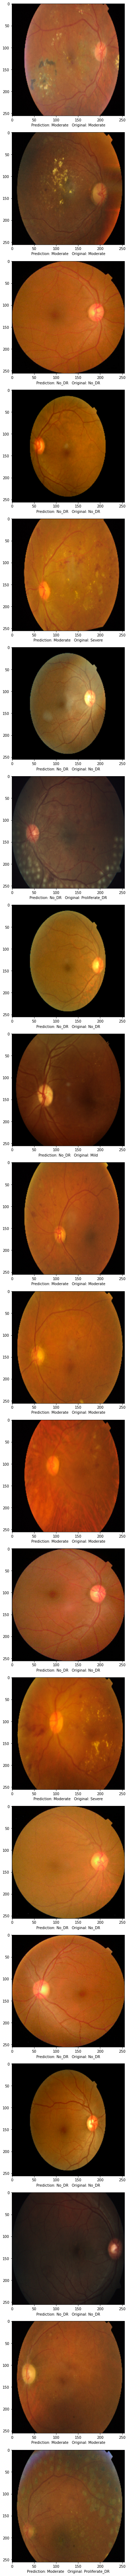

In [15]:
# Visualizing the results
import random
fig=plt.figure(figsize = (100,100))
for i in range(20):
    j = random.randint(0,len(image))
    fig.add_subplot(20, 1, i+1)
    plt.xlabel("Prediction: " + prediction[j] +"   Original: " + original[j])
    plt.imshow(image[j])
fig.tight_layout()
plt.show()

In [16]:
from sklearn.metrics import roc_curve,auc
print(classification_report(np.asarray(original), np.asarray(prediction), zero_division=1))

                precision    recall  f1-score   support

          Mild       0.47      0.08      0.14        88
      Moderate       0.51      0.92      0.66       190
         No_DR       0.92      0.97      0.94       356
Proliferate_DR       1.00      0.00      0.00        64
        Severe       1.00      0.00      0.00        35

      accuracy                           0.72       733
     macro avg       0.78      0.39      0.35       733
  weighted avg       0.77      0.72      0.65       733



In [17]:
from sklearn.metrics import multilabel_confusion_matrix

def get_accuracies(true_labels, predictions):
    cm = multilabel_confusion_matrix(true_labels, predictions)
    total_count = len(test)
    accuracies = []
    for i in range(5):
        true_positive_count = np.sum(cm[i,1,1]).item()
        true_negative_count = np.sum(cm[i,0,0]).item()
        accuracy = (true_positive_count + true_negative_count) / total_count
        accuracies.append(accuracy)
    return accuracies
list4=[]
list4= get_accuracies(original, prediction)
a=[]
b=[]
for i in labels:
  a.append(labels[i])
  b.append(list4[i])
c = pd.DataFrame({'Labels': a, 'Accuracy': b})
c

Labels  Accuracy
0            Mild  0.878581
1        Moderate  0.754434
2           No_DR  0.942701
3  Proliferate_DR  0.912688
4          Severe  0.952251

Text(0.5, 1.0, 'Confusion_matrix')

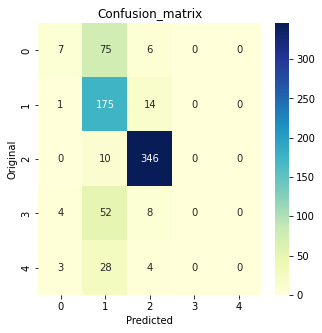

In [18]:
import seaborn as sns
plt.figure(figsize = (5,5))
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax, cmap="YlGnBu", fmt = 'g')

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion_matrix')

In [19]:
FP = cm.sum(axis=0) - np.diag(cm) 
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)
sensitivity = (TP/(TP + FN))
specificity = (TN/(TN + FP))

print("Sensitivity : "+str(sensitivity))
print("Specificity : "+str(specificity))

Sensitivity : [0.07954545 0.92105263 0.97191011 0.         0.        ]
Specificity : [0.9875969  0.6961326  0.91511936 1.         1.        ]


In [20]:
from sklearn import preprocessing
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import roc_auc_score
def multiclass_roc_auc_score(list1, list2, average="macro"):
  lb = preprocessing.LabelBinarizer()
  lb.fit(list1)
  list1 = lb.transform(list1)
  list2 = lb.transform(list2)
  return roc_auc_score(list1, list2, average=average)

In [21]:
from sklearn.preprocessing import label_binarize
list1=[]
list2=[]
lb = preprocessing.LabelBinarizer()
lb.fit(original)
lb.fit(prediction)

list1 =lb.transform(original)
list2 =lb.transform(prediction)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


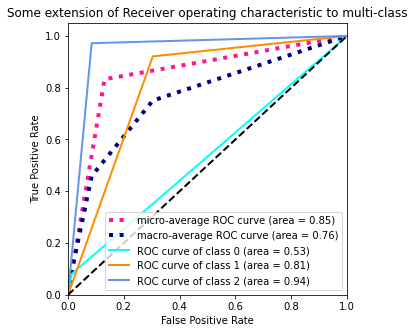

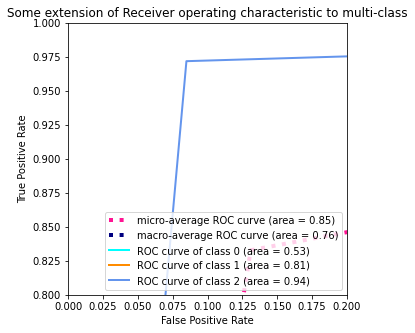

In [22]:
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle

n_classes = 3

from sklearn.metrics import roc_curve, auc

# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(list1[:, i],list2[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(list1.ravel(), list2.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(5,5))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()


# Zoom in view of the upper left corner.
plt.figure(figsize=(5,5))
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()


In [23]:
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
def multiclass_roc_auc_score(list1, list2, average="macro"):
  lb = preprocessing.LabelBinarizer()
  lb.fit(list1)
  list1 = lb.transform(list1)
  list2 = lb.transform(list2)
  return roc_auc_score(list1, list2, average=average)
print("AUC score: ", multiclass_roc_auc_score(original,prediction))

AUC score:  0.6571357057789067


In [24]:
from sklearn.metrics import cohen_kappa_score
kappa = cohen_kappa_score(original,prediction)
print('Cohens Kappa: %.3f' % kappa)

Cohens Kappa: 0.554
